In [1]:
import sys
sys.path.append('../..')
import scripts.radossim as sim
import matplotlib.pyplot as plt
print('done.')

done.


In [11]:
def printResults(avgThroughput, avgOsdQueueLen, data, timeLog=None, batchSizeLog=None):
    print()
    print('Results:')
    print(f'\t avg Throughput: {avgThroughput} MB/s')
    print(f'\t avg Osd Queue Size: {avgOsdQueueLen}')
    avgBlueStoreLat = 0
    avgKVQueueLat = 0
    for (((((_, _, _), _), arrivalKV), _, _), kvQDispatch, kvCommit) in data:
        avgBlueStoreLat += kvCommit - arrivalKV
        avgKVQueueLat += kvQDispatch - arrivalKV
    avgBlueStoreLat /= len(data)
    avgKVQueueLat /= len(data)
    avgBlueStoreLat /= 1_000
    avgKVQueueLat /= 1_000
    print(f'\t avg BlueStore Latency: {avgBlueStoreLat} ms')
    print(f'\t avg KV Queue Latency: {avgKVQueueLat} ms')
    print()
    time = [arrivalKV for (((((_, _, _), _), arrivalKV), _, _), _, _) in data]
    kvQueueLats = [kvQDispatch - arrivalKV for (((((_, _, _), _), arrivalKV), _, _), kvQDispatch, _) in data]
    bluestoreLats = [kvCommit - arrivalKV for (((((_, _, _), _), arrivalKV), _, _), _, kvCommit) in data]
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid(True)
    ax.set_xlabel('time')
    if batchSizeLog:
        ax.plot(timeLog, batchSizeLog, color='green', label='Batch Size History')
        fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time, kvQueueLats, color='red', label='KV Queuing Latency')
    ax.plot(time, bluestoreLats, color='blue', label='BlueStore Latency')
    plt.show()

def printTitle(title):
    print('************************************************')
    print(title)
    print('************************************************')
    print()
    
def printSeparator():
    print()
    print('=========================================================')
    print()

In [9]:
def runSimulations(targetLatSettings = [100],
                   intervalSettings = [1000],
                   batchDownSizeSettings = [2],
                   batchUpSizeSettings = [1],
                   simulationTimeSettings = [10 * 1_000_000],
                   modelPath = '../latModel/latency_model_4K.yaml'
                  ):
    printTitle('Simulation without CoDel')

    print('Simulation running...')
    avgThroughput, avgOsdQueueLen, data, _, _ = sim.runSimulation(
        modelPath,
        0,
        0,
        simulationTimeSettings[0],
        useCoDel=False,
        downSize=1,
        upSize=1
    )
    avgThroughput = avgThroughput / 1024
    avgThroughput = avgThroughput / 1024
    print('Simulation done')

    printResults(avgThroughput, avgOsdQueueLen, data)


    printTitle('Simulation with CoDel')

    i = 1
    for time in simulationTimeSettings:
        for targetLat in targetLatSettings:
            for interval in intervalSettings:
                for downSize in batchDownSizeSettings:
                    for upSize in batchUpSizeSettings:
                        print(f'Simulation profile #{i}:')
                        print(f'\t time: {time}')
                        print(f'\t targetLat: {targetLat}')
                        print(f'\t interval: {interval}')
                        print(f'\t downSize: {downSize}')
                        print(f'\t upSize: {upSize}')
                        print()
                        print('\t Simulation running...')
                        avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog = sim.runSimulation(
                            modelPath,
                            targetLat,
                            interval,
                            time,
                            useCoDel=True,
                            downSize=downSize,
                            upSize=upSize
                        )
                        avgThroughput = avgThroughput / 1024
                        avgThroughput = avgThroughput / 1024
                        print('\t Simulation done')
                        printResults(avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog)
                        printSeparator()
                        i += 1


************************************************
Simulation without CoDel
************************************************

Simulation running...
L0 Compaction
134158.0
Simulation done

Results:
	 avg Throughput: 52.40546875 MB/s
	 avg Osd Queue Size: 0.49999813656031394
	 avg BlueStore Latency: 1.4143649173305806 ms
	 avg KV Queue Latency: 0.623137931994718 ms



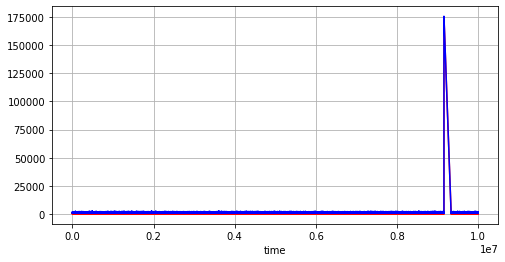

************************************************
Simulation with CoDel
************************************************

Simulation profile #1:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
22883.0
	 Simulation done

Results:
	 avg Throughput: 8.938671875 MB/s
	 avg Osd Queue Size: 18.7045936087023
	 avg BlueStore Latency: 1.7647305978749792 ms
	 avg KV Queue Latency: 0.9994511118265682 ms



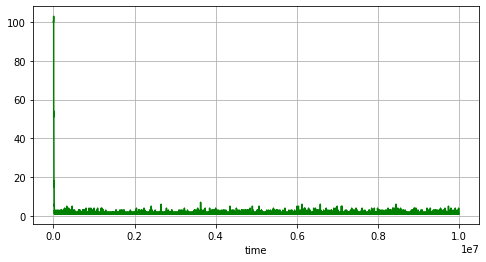

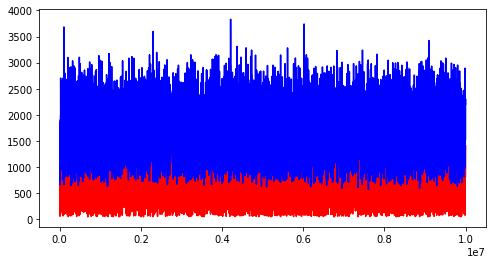



Simulation profile #2:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 2

	 Simulation running...
Using CoDel algorithm ...
24699.0
	 Simulation done

Results:
	 avg Throughput: 9.648046875 MB/s
	 avg Osd Queue Size: 17.869832662228607
	 avg BlueStore Latency: 1.76591152393493 ms
	 avg KV Queue Latency: 1.0011012437650264 ms



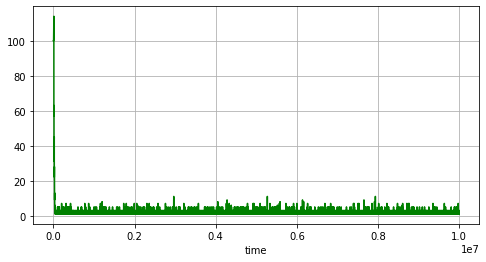

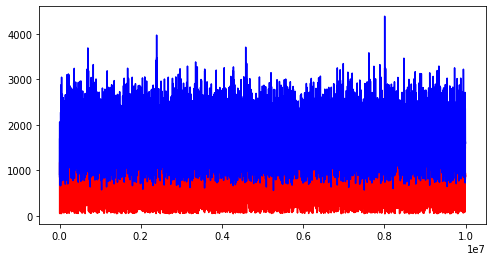



Simulation profile #3:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 4

	 Simulation running...
Using CoDel algorithm ...
78668.0
	 Simulation done

Results:
	 avg Throughput: 30.7296875 MB/s
	 avg Osd Queue Size: 3.5243164571443097
	 avg BlueStore Latency: 1.4463651432730793 ms
	 avg KV Queue Latency: 0.681970905001549 ms



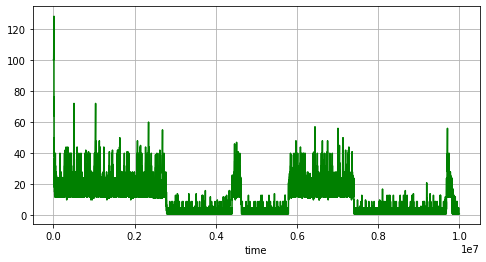

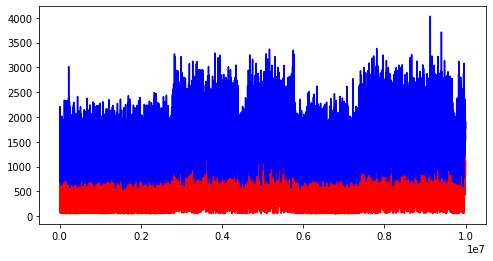



Simulation profile #4:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 8

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
133584.0
	 Simulation done

Results:
	 avg Throughput: 52.18125 MB/s
	 avg Osd Queue Size: 0.4999981285253903
	 avg BlueStore Latency: 1.4166914270144773 ms
	 avg KV Queue Latency: 0.6284377049062957 ms



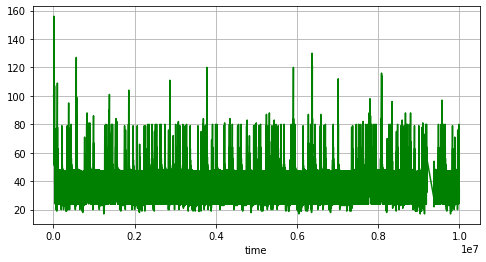

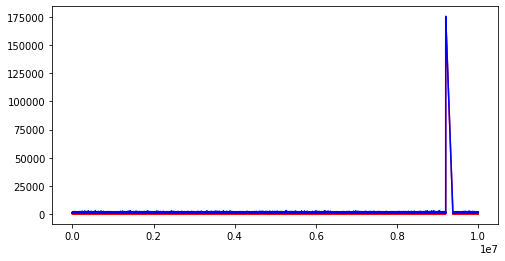



Simulation profile #5:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 16

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
133969.0
	 Simulation done

Results:
	 avg Throughput: 52.331640625 MB/s
	 avg Osd Queue Size: 0.49999813418215605
	 avg BlueStore Latency: 1.4139853014407537 ms
	 avg KV Queue Latency: 0.6217208762666053 ms



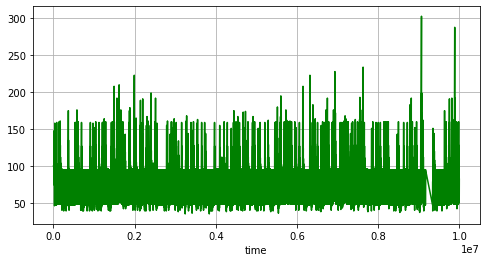

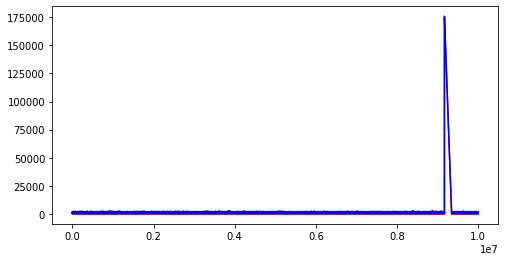



Simulation profile #6:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 4
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
22825.0
	 Simulation done

Results:
	 avg Throughput: 8.916015625 MB/s
	 avg Osd Queue Size: 18.803590585659553
	 avg BlueStore Latency: 1.7617605274082038 ms
	 avg KV Queue Latency: 0.9987442659399213 ms



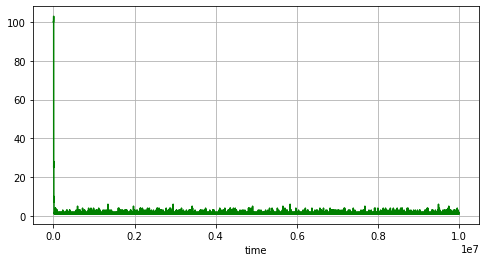

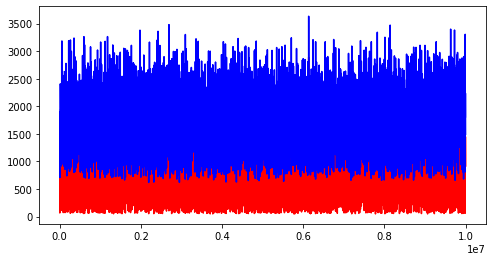



Simulation profile #7:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 4
	 upSize: 2

	 Simulation running...
Using CoDel algorithm ...
24404.0
	 Simulation done

Results:
	 avg Throughput: 9.5328125 MB/s
	 avg Osd Queue Size: 18.044985462140136
	 avg BlueStore Latency: 1.7639889271634372 ms
	 avg KV Queue Latency: 0.9986578382738143 ms



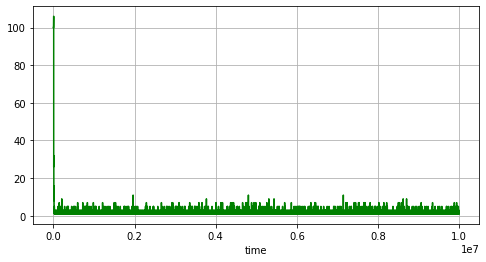

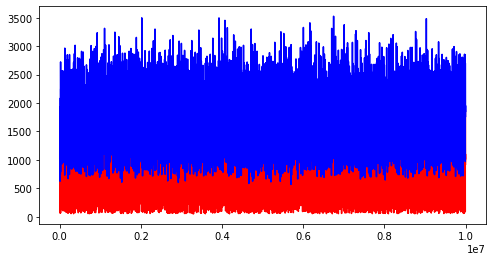



Simulation profile #8:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 4
	 upSize: 4

	 Simulation running...
Using CoDel algorithm ...
27900.0
	 Simulation done

Results:
	 avg Throughput: 10.8984375 MB/s
	 avg Osd Queue Size: 16.252328080229226
	 avg BlueStore Latency: 1.7583450772335532 ms
	 avg KV Queue Latency: 0.9930485347804247 ms



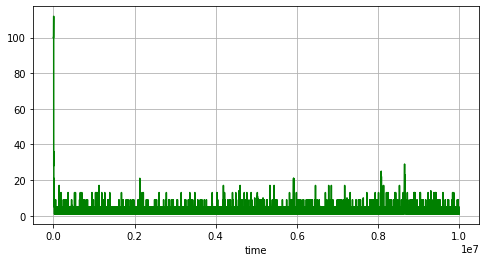

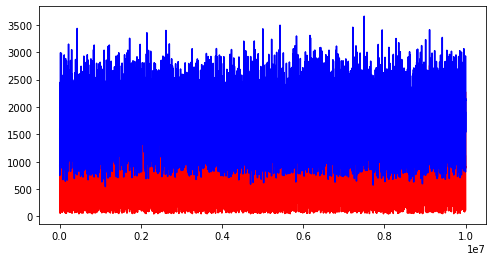



Simulation profile #9:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 4
	 upSize: 8

	 Simulation running...
Using CoDel algorithm ...
46988.0
	 Simulation done

Results:
	 avg Throughput: 18.3546875 MB/s
	 avg Osd Queue Size: 8.20667127733149
	 avg BlueStore Latency: 1.6104929669208674 ms
	 avg KV Queue Latency: 0.8399268079541523 ms



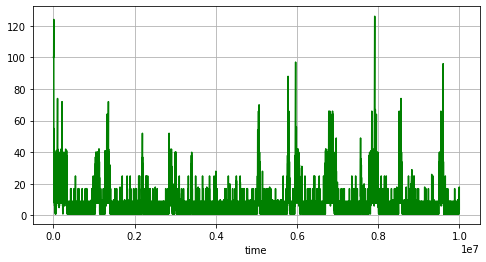

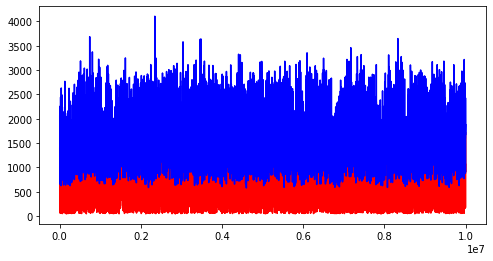



Simulation profile #10:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 4
	 upSize: 16

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
133681.0
	 Simulation done

Results:
	 avg Throughput: 52.219140625 MB/s
	 avg Osd Queue Size: 0.5004917891776463
	 avg BlueStore Latency: 1.4164789611269355 ms
	 avg KV Queue Latency: 0.6252228134429313 ms



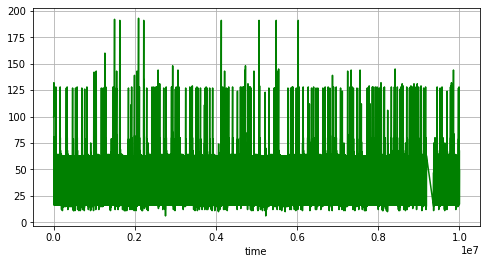

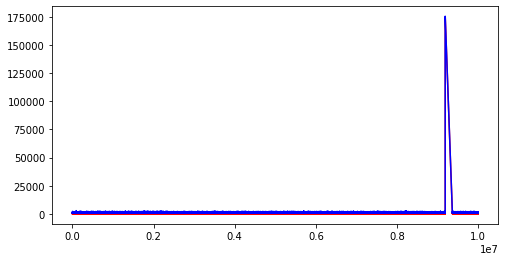



Simulation profile #11:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 8
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
22687.0
	 Simulation done

Results:
	 avg Throughput: 8.862109375 MB/s
	 avg Osd Queue Size: 18.853016984997687
	 avg BlueStore Latency: 1.7639683061909697 ms
	 avg KV Queue Latency: 0.9984117024432415 ms



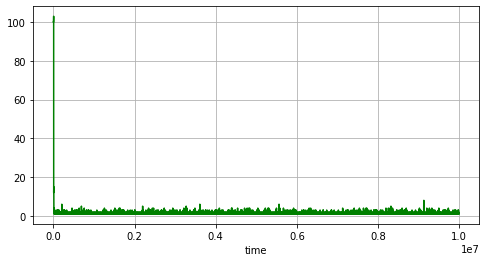

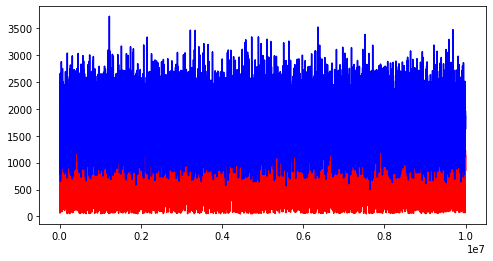



Simulation profile #12:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 8
	 upSize: 2

	 Simulation running...
Using CoDel algorithm ...
24468.0
	 Simulation done

Results:
	 avg Throughput: 9.5578125 MB/s
	 avg Osd Queue Size: 18.018692543411646
	 avg BlueStore Latency: 1.7649604003801576 ms
	 avg KV Queue Latency: 0.9988860938166627 ms



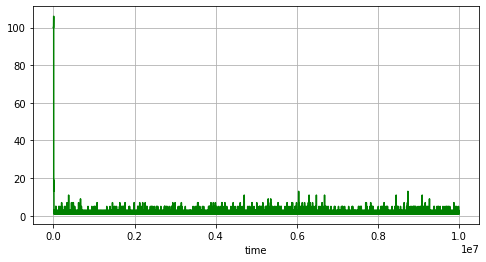

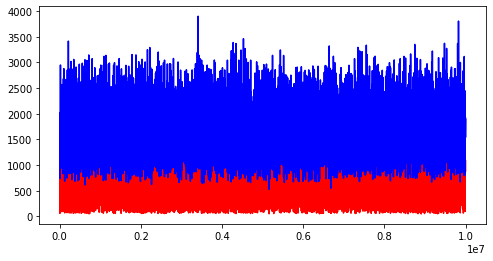



Simulation profile #13:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 8
	 upSize: 4

	 Simulation running...
Using CoDel algorithm ...
27784.0
	 Simulation done

Results:
	 avg Throughput: 10.853125 MB/s
	 avg Osd Queue Size: 16.362463564719853
	 avg BlueStore Latency: 1.7518344457898163 ms
	 avg KV Queue Latency: 0.9867657566568645 ms



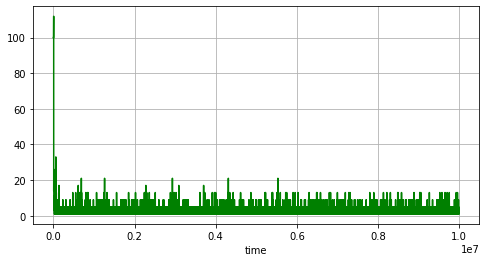

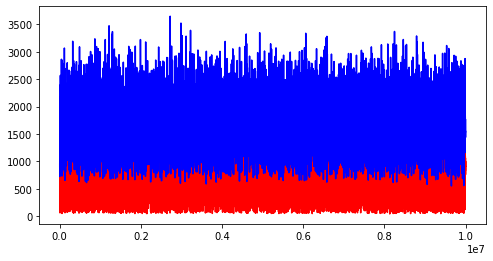



Simulation profile #14:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 8
	 upSize: 8

	 Simulation running...
Using CoDel algorithm ...
33627.0
	 Simulation done

Results:
	 avg Throughput: 13.135546875 MB/s
	 avg Osd Queue Size: 13.438455935906774
	 avg BlueStore Latency: 1.7293752137451024 ms
	 avg KV Queue Latency: 0.9668491364182876 ms



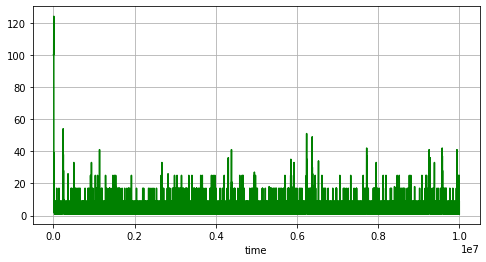

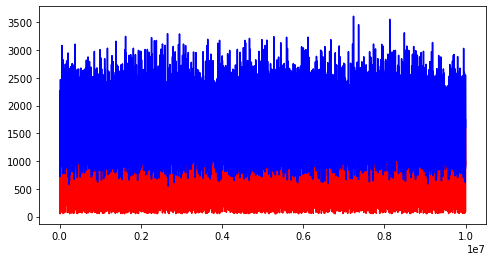



Simulation profile #15:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 8
	 upSize: 16

	 Simulation running...
Using CoDel algorithm ...
66569.0
	 Simulation done

Results:
	 avg Throughput: 26.003515625 MB/s
	 avg Osd Queue Size: 4.708378394616679
	 avg BlueStore Latency: 1.5680130872550002 ms
	 avg KV Queue Latency: 0.8040592385513742 ms



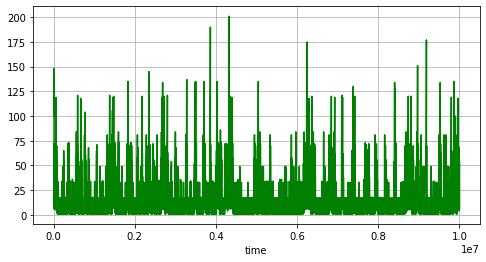

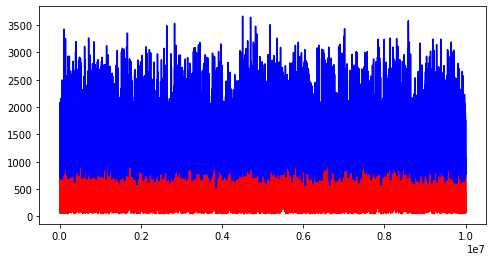



Simulation profile #16:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 16
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
22741.0
	 Simulation done

Results:
	 avg Throughput: 8.883203125 MB/s
	 avg Osd Queue Size: 18.891262776129246
	 avg BlueStore Latency: 1.7637921327614197 ms
	 avg KV Queue Latency: 0.9999300848485806 ms



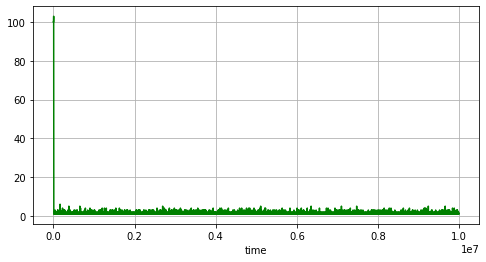

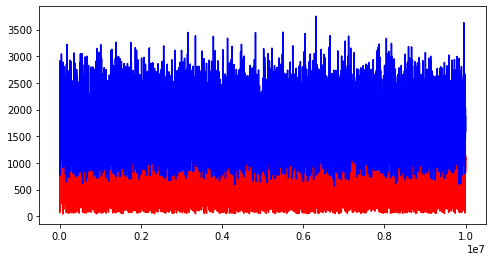



Simulation profile #17:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 16
	 upSize: 2

	 Simulation running...
Using CoDel algorithm ...
24504.0
	 Simulation done

Results:
	 avg Throughput: 9.571875 MB/s
	 avg Osd Queue Size: 18.140223509258504
	 avg BlueStore Latency: 1.7633215600667946 ms
	 avg KV Queue Latency: 0.9974998982613404 ms



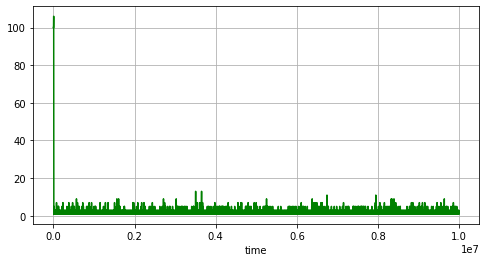

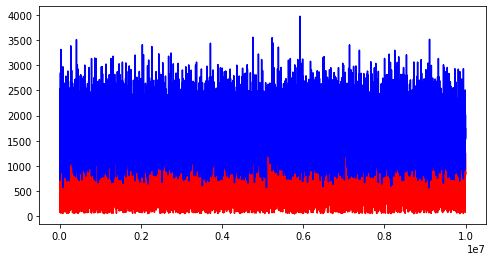



Simulation profile #18:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 16
	 upSize: 4

	 Simulation running...
Using CoDel algorithm ...
27018.0
	 Simulation done

Results:
	 avg Throughput: 10.55390625 MB/s
	 avg Osd Queue Size: 16.837342263997336
	 avg BlueStore Latency: 1.765248320902069 ms
	 avg KV Queue Latency: 0.995824228987459 ms



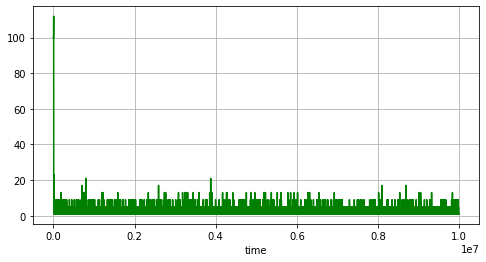

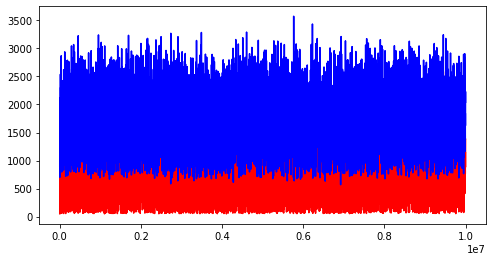



Simulation profile #19:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 16
	 upSize: 8

	 Simulation running...
Using CoDel algorithm ...
33762.0
	 Simulation done

Results:
	 avg Throughput: 13.18828125 MB/s
	 avg Osd Queue Size: 13.554710166380485
	 avg BlueStore Latency: 1.7342853858195675 ms
	 avg KV Queue Latency: 0.9700980641674914 ms



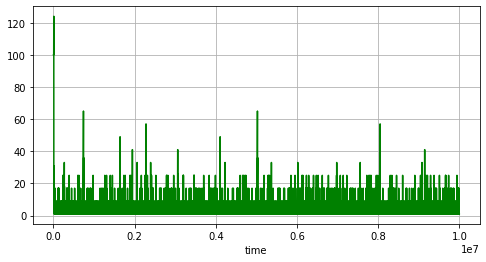

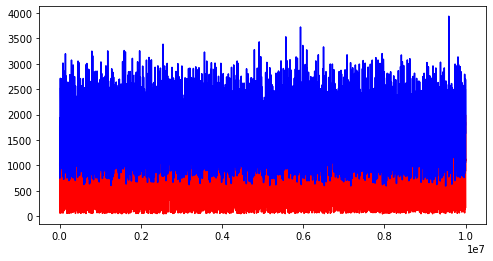



Simulation profile #20:
	 time: 10000000
	 targetLat: 750
	 interval: 500
	 downSize: 16
	 upSize: 16

	 Simulation running...
Using CoDel algorithm ...
46918.0
	 Simulation done

Results:
	 avg Throughput: 18.32734375 MB/s
	 avg Osd Queue Size: 7.986192789567886
	 avg BlueStore Latency: 1.67461585590407 ms
	 avg KV Queue Latency: 0.907796197784028 ms



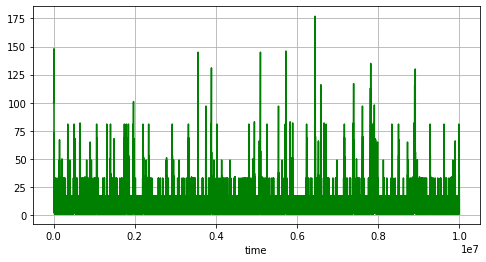

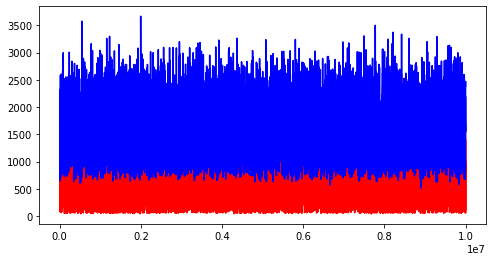

In [12]:
targetLatSettings = [750]
intervalSettings = [500]
batchDownSizeSettings = [2, 4, 8, 16]
batchUpSizeSettings = [1, 2, 4, 8, 16]

runSimulations(targetLatSettings,
                   intervalSettings,
                   batchDownSizeSettings,
                   batchUpSizeSettings,
                  )

************************************************
Simulation without CoDel
************************************************

Simulation running...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
L0 Compaction
798498.0
Simulation done

Results:
	 avg Throughput: 51.985546875 MB/s
	 avg Osd Queue Size: 0.4999996869143341
	 avg BlueStore Latency: 1.4100505051015013 ms
	 avg KV Queue Latency: 0.6149992867306187 ms

************************************************
Simulation with CoDel
************************************************

Simulation profile #1:
	 time: 60000000
	 targetLat: 250
	 interval: 100
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
130373.0
	 Simulation done

Results:
	 avg Throughput: 8.487825520833333 MB/s
	 avg Osd Queue Size: 19.170827853042567
	 avg BlueStore Latency: 1.7620924321411737 ms
	 avg KV Queue Latency: 0.9939575531834892 ms

	 Batch Size History:


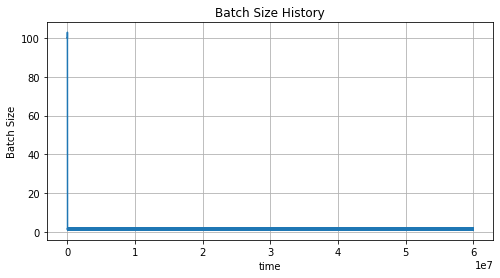



Simulation profile #2:
	 time: 60000000
	 targetLat: 250
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
130349.0
	 Simulation done

Results:
	 avg Throughput: 8.486263020833333 MB/s
	 avg Osd Queue Size: 19.184424610404307
	 avg BlueStore Latency: 1.7625254219773865 ms
	 avg KV Queue Latency: 0.9944122287526643 ms

	 Batch Size History:


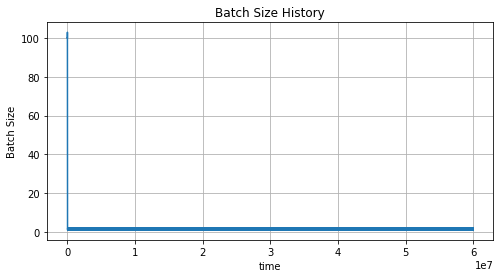



Simulation profile #3:
	 time: 60000000
	 targetLat: 250
	 interval: 1000
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
135615.0
	 Simulation done

Results:
	 avg Throughput: 8.8291015625 MB/s
	 avg Osd Queue Size: 18.713894428736264
	 avg BlueStore Latency: 1.756598958659032 ms
	 avg KV Queue Latency: 0.9898204015855108 ms

	 Batch Size History:


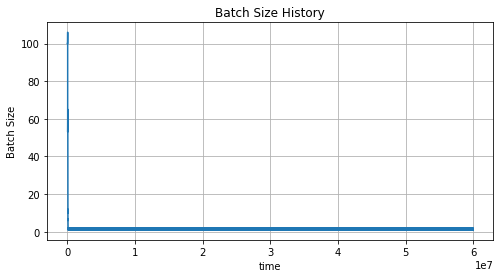



Simulation profile #4:
	 time: 60000000
	 targetLat: 500
	 interval: 100
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
130537.0
	 Simulation done

Results:
	 avg Throughput: 8.498502604166667 MB/s
	 avg Osd Queue Size: 19.160096361916363
	 avg BlueStore Latency: 1.761350892511181 ms
	 avg KV Queue Latency: 0.9938066334007752 ms

	 Batch Size History:


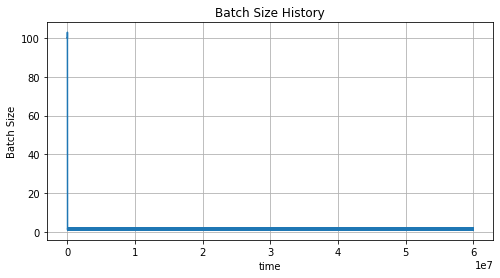



Simulation profile #5:
	 time: 60000000
	 targetLat: 500
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
130561.0
	 Simulation done

Results:
	 avg Throughput: 8.500065104166667 MB/s
	 avg Osd Queue Size: 19.157217531162043
	 avg BlueStore Latency: 1.7608896553439746 ms
	 avg KV Queue Latency: 0.9936965567853996 ms

	 Batch Size History:


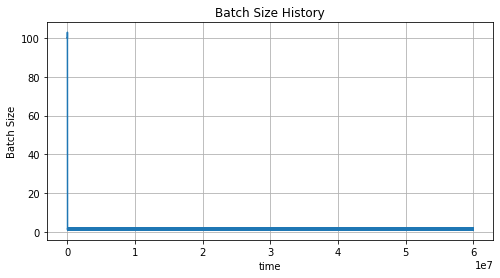



Simulation profile #6:
	 time: 60000000
	 targetLat: 500
	 interval: 1000
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
138258.0
	 Simulation done

Results:
	 avg Throughput: 9.001171875 MB/s
	 avg Osd Queue Size: 18.30706423478022
	 avg BlueStore Latency: 1.750589784871654 ms
	 avg KV Queue Latency: 0.9830624869087341 ms

	 Batch Size History:


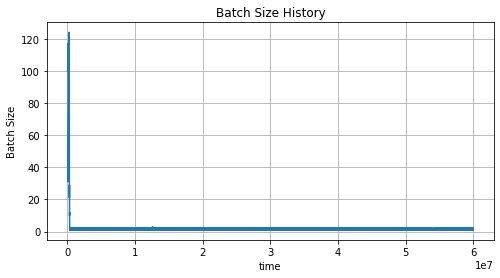



Simulation profile #7:
	 time: 60000000
	 targetLat: 750
	 interval: 100
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
135555.0
	 Simulation done

Results:
	 avg Throughput: 8.8251953125 MB/s
	 avg Osd Queue Size: 18.92068257170359
	 avg BlueStore Latency: 1.7720015377300944 ms
	 avg KV Queue Latency: 1.004242712294244 ms

	 Batch Size History:


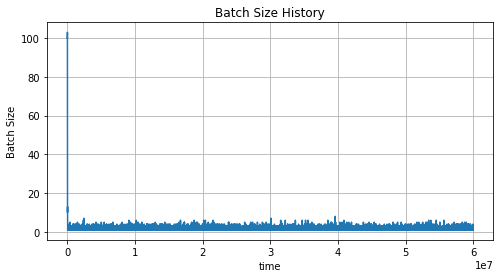



Simulation profile #8:
	 time: 60000000
	 targetLat: 750
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
135513.0
	 Simulation done

Results:
	 avg Throughput: 8.8224609375 MB/s
	 avg Osd Queue Size: 18.932382031010782
	 avg BlueStore Latency: 1.7722430503200695 ms
	 avg KV Queue Latency: 1.0053210542285158 ms

	 Batch Size History:


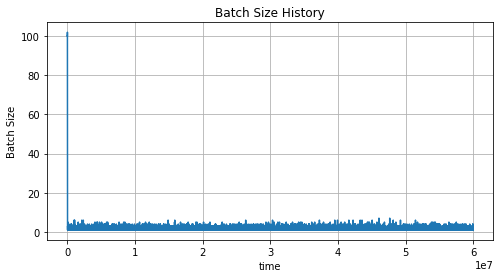



Simulation profile #9:
	 time: 60000000
	 targetLat: 750
	 interval: 1000
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
155224.0
	 Simulation done

Results:
	 avg Throughput: 10.105729166666666 MB/s
	 avg Osd Queue Size: 16.94366065619182
	 avg BlueStore Latency: 1.7369960830861753 ms
	 avg KV Queue Latency: 0.9682640381493245 ms

	 Batch Size History:


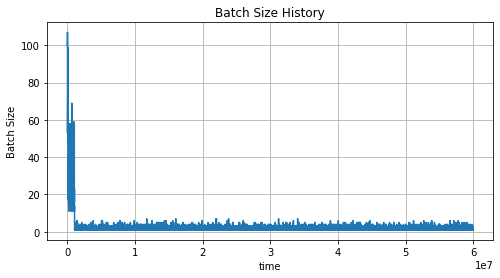



Simulation profile #10:
	 time: 60000000
	 targetLat: 1000
	 interval: 100
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
643165.0
	 Simulation done

Results:
	 avg Throughput: 41.872721354166664 MB/s
	 avg Osd Queue Size: 2.501002829689978
	 avg BlueStore Latency: 1.5212990044551489 ms
	 avg KV Queue Latency: 0.7261592604798809 ms

	 Batch Size History:


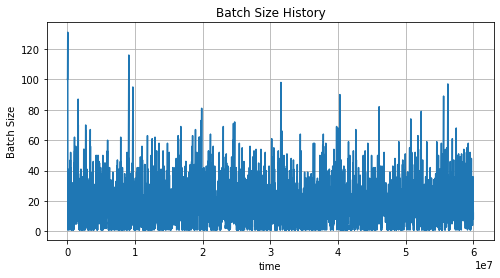



Simulation profile #11:
	 time: 60000000
	 targetLat: 1000
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
636032.0
	 Simulation done

Results:
	 avg Throughput: 41.40833333333333 MB/s
	 avg Osd Queue Size: 2.6211811410490733
	 avg BlueStore Latency: 1.526573514991249 ms
	 avg KV Queue Latency: 0.7267738031496666 ms

	 Batch Size History:


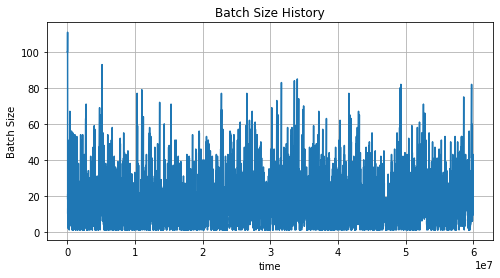



Simulation profile #12:
	 time: 60000000
	 targetLat: 1000
	 interval: 1000
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
L0 Compaction
764017.0
	 Simulation done

Results:
	 avg Throughput: 49.74069010416667 MB/s
	 avg Osd Queue Size: 0.919037793400961
	 avg BlueStore Latency: 1.4364052627874686 ms
	 avg KV Queue Latency: 0.6426048797561885 ms

	 Batch Size History:


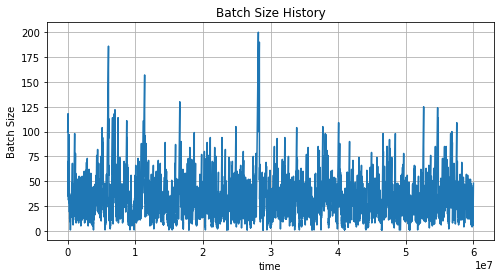



Simulation profile #13:
	 time: 60000000
	 targetLat: 1250
	 interval: 100
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
L0 Compaction
799345.0
	 Simulation done

Results:
	 avg Throughput: 52.040690104166664 MB/s
	 avg Osd Queue Size: 0.5001873370183578
	 avg BlueStore Latency: 1.4158239688236738 ms
	 avg KV Queue Latency: 0.6159949804010775 ms

	 Batch Size History:


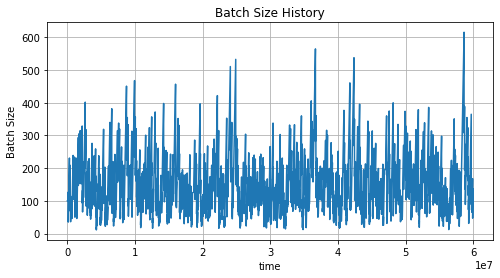



Simulation profile #14:
	 time: 60000000
	 targetLat: 1250
	 interval: 500
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
L0 Compaction
800133.0
	 Simulation done

Results:
	 avg Throughput: 52.0919921875 MB/s
	 avg Osd Queue Size: 0.5003758700783048
	 avg BlueStore Latency: 1.4094653762409508 ms
	 avg KV Queue Latency: 0.6141558433342312 ms

	 Batch Size History:


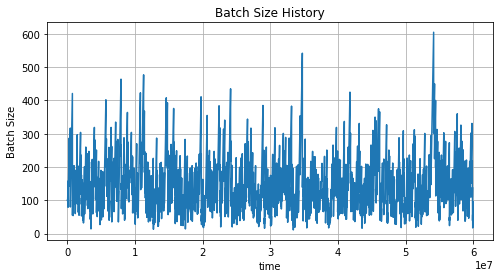



Simulation profile #15:
	 time: 60000000
	 targetLat: 1250
	 interval: 1000
	 downSize: 2
	 upSize: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
L0 Compaction
799626.0
	 Simulation done

Results:
	 avg Throughput: 52.058984375 MB/s
	 avg Osd Queue Size: 0.5011552181783506
	 avg BlueStore Latency: 1.4083113453369933 ms
	 avg KV Queue Latency: 0.6133741468058143 ms

	 Batch Size History:


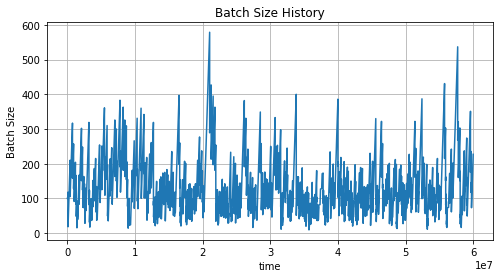

In [19]:
targetLatSettings = [250, 500, 750, 1000, 1250]
intervalSettings = [100, 500, 1000]
batchDownSizeSettings = [2]
batchUpSizeSettings = [1]

runSimulations(targetLatSettings,
                   intervalSettings,
                   batchDownSizeSettings,
                   batchUpSizeSettings,
                  )